# Spec2Vec - Some further optimization

## Main datasets here:
1. all spectra from gnps libraries (2019) with smiles annotations.  


## Outline:
1. Importing, creating documents
2. Plotting functions
3. For benchmarking: molecular similarity
4. Spec2Vec - Spec2Vec trained on **unique smiles** dataset  
5. Spec2Vec - Spec2Vec trained on **all-GNPS dataset**, 2 decimals  
5.1. Word vectors weighted by tfidf * norm(intensity) + retraining by 5 epochs  
5.2. Word vectors weighted by tfidf * sqrt(norm(intensity)) + retraining by 5 epochs   
6. Spec2Vec - Spec2Vec trained on **all-GNPS dataset**, 3 decimals  
6.1. 3 decimals, weighted by tfidf * sqrt(norm(intensity)) + retraining by 5 epochs  
6.2. 3 decimals, d = 400, weighted by tfidf * sqrt(norm(intensity)) + retraining by 5 epochs  
7. Spec2Vec - Spec2Vec trained on **all-GNPS dataset**, 1 decimals  
7.1. Word vectors weighted by tfidf * norm(intensity) + retraining by 5 epochs  
8. Spec2Vec - Spec2Vec trained on **all-merged dataset**, 2 decimals  
5.1. Word vectors weighted by tfidf * norm(intensity) + retraining by 5 epochs 


## 1. Importing, creating documents for reference dataset (1 - unique-smiles)

In [1]:
# data locations
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"
PATH_MS_DATA = ROOT + "\\Data\\GNPS_all\\"
PATH_SAVE_MODEL = ROOT + "\\SeSiMe\\models_trained\\"
PATH_SAVE_DATA = ROOT + "\\SeSiMe\\data\\"
PATH_SESIME = ROOT + "\\SeSiMe\\"

PATH_NPLINKER = ROOT + "\\nplinker\\prototype\\"
mgf_file = PATH_MS_DATA + "all_gnps_with_smiles_190915.mgf"

In [2]:
# import general packages
import sys
sys.path.insert(0, PATH_NPLINKER)
sys.path.insert(0, PATH_SESIME)

import helper_functions as functions
import MS_functions

import numpy as np
from metabolomics import load_spectra

In [3]:
# Import / Load data from dataset
results_file = "filtered_data_LibrariesAllSmiles_minpeak10_loss500_2dec_exp001.json"

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(PATH_SAVE_DATA,
                  mgf_file, 
                 results_file = results_file,
                 num_decimals = 2,
                 min_frag = 0.0, max_frag = 1000.0,
                 min_loss = 5.0, max_loss = 500.0,
                 min_intensity_perc = 0,
                 exp_intensity_filter = 0.01,
                 min_peaks = 10,
                 max_peaks = None,
                 peaks_per_mz = 15/200,
                 peak_loss_words = ['peak_', 'loss_'],
                 sub_spectra = False)

Spectra json file found and loaded.


In [4]:
len(spectra), len(spectra_dict)

(55937, 55937)

### Compare to reference dataset (unique smiles)

In [5]:
# Import / Load reference data from dataset
results_file = "filtered_data_uniquesmiles_minpeak10_no_losses_2dec_exp001.json"

spectra_ref, spectra_dict_ref, MS_documents_ref, MS_documents_intensity_ref, sub_spectra_metadata_ref = MS_functions.load_MGF_data(PATH_SAVE_DATA,
                  mgf_file, 
                 results_file = results_file,
                 num_decimals = 2,
                 min_frag = 0.0, max_frag = 1000.0,
                 min_loss = 5.0, max_loss = 500.0,
                 min_intensity_perc = 0,
                 exp_intensity_filter = 0.01,
                 min_peaks = 10,
                 max_peaks = None,
                 peaks_per_mz = 15/200,
                 peak_loss_words = ['peak_', 'loss_'],
                 sub_spectra = False)

Spectra json file found and loaded.


In [6]:
# compare allGNPS and uniquesmiles MGFs
find_precursor_matches = []
find_precursor_matches_confirmed = []
find_precursor_matches_not_confirmed = []
find_precursor_matches_1 = []
find_target_matched = np.zeros((len(spectra_ref)))

# set minimal precision
decimals = 4

target_mz = np.array(sub_spectra_metadata_ref['precursor_mz'])
target_mz  = np.round(target_mz, decimals)

for i, precursor_mz in enumerate(sub_spectra_metadata['precursor_mz']):
    found_ones = np.where(target_mz == np.round(precursor_mz, decimals))[0]
    if len(found_ones) > 0:
        find_precursor_matches.append(1)
        cosine_scores = []
        for one in found_ones:
            cosine_scores.append(MS_functions.cosine_score(spectra[i], spectra_ref[one], tol = 0.005)[0])
        find_precursor_matches_1.append((i, precursor_mz, found_ones, cosine_scores))   
        if max(cosine_scores) > 0.5:
            find_precursor_matches_confirmed.append((i, max(cosine_scores)))
        else:
            find_precursor_matches_not_confirmed.append((i, max(cosine_scores)))
    else:
        find_precursor_matches.append(0)

print("Found", np.sum(np.array(find_precursor_matches)), " matches.")
found_IDX = np.where(np.array(find_precursor_matches) == 1)

print("Found", len(find_precursor_matches_confirmed), " cosine score confirmed matches.")

Found 15792  matches.
Found 1673  cosine score confirmed matches.


### Note:
This means that there are 15792 matching precursor m/z, but only 1673 of those matches have a cosine score > 0.5

#### Switch to general SeSiMe functionality
Once we have a corpus (e.g. through cells above), we can use SeSiMe to apply different similarity measuring methds. 

In [146]:
from Similarities import SimilarityMeasures

MS_measure = SimilarityMeasures(MS_documents)

In [147]:
MS_measure.preprocess_documents(0.2, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_measure.dictionary))

Preprocess documents...
Number of unique words:  68392


***
## 2. Plotting functions

In [9]:
import matplotlib
from matplotlib import pyplot as plt

def binned_scatter_plot(bins_x, 
                        bins_y, 
                        H, 
                        edges, 
                        label):
    data_x = []
    data_y = []
    data_z = []
    data_y_mean = []
    for i in range(bins_x):
        for j in range(bins_y):
            data_x.append(edges[0][i] + 0.5*np.diff(edges[0][:2])[0])
            data_y.append(edges[1][j] + 0.5*np.diff(edges[1][:2])[0])
            mean_mol_score = np.sum(H[i,:]*(edges[1][:bins_y] + edges[1][1]/2))/(np.sum(H[i,:]))
            data_y_mean.append(mean_mol_score)
            data_z.append(np.sum(H[i,j]))#/np.sum(H[i,:]))
            
    fig, ax = plt.subplots(figsize=(15,10))
    cm = plt.cm.get_cmap('viridis')
    #100*np.array(data_z)**0.5 c=data_y, 
    ax.scatter(data_x, data_y, s=1*np.array(data_z)**0.5, c=data_y, cmap=cm, alpha=0.6)
    plt.plot(data_x, data_y_mean, color='black')
    plt.xlabel("g(s,s') (" + label + ")")
    plt.ylabel("molecular similarity (f(t,t'))")

    # Optionally add a colorbar
    max_color = np.max(data_y)
    min_color = np.min(data_y)
    color_ticks = np.round(np.linspace(min_color, max_color, 6),2)
    cax, _ = matplotlib.colorbar.make_axes(ax)
    cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
    cbar.ax.set_yticklabels([x for x in list(color_ticks)])
    plt.ylabel("molecular similarity (f(t,t'))")

In [10]:
def plot_high_sim_percentile(A, B, num_bins = 10000, show_top_percentile = 1.0):
    
    Asort = np.sort(A)
    starting_point = Asort[int(A.shape[0] - A.shape[0]*show_top_percentile/100)]
    if starting_point == 0:
        print("not enough datapoints != 0 above given top-precentile")
        
    low_As = np.where(A < starting_point)[0]
    A_select = np.delete(A, low_As)
    B_select = np.delete(B, low_As)

    length_selected = A_select.shape[0]
    Data = np.zeros((2, length_selected))
    Data[0,:] = A_select
    Data[1,:] = B_select
    Data = Data[:,np.lexsort((Data[1,:], Data[0,:]))]

    ref_score_cum = []
    
    for i in range(num_bins):
        low = int(i * length_selected/num_bins)
        high = int((i+1) * length_selected/num_bins)
        ref_score_cum.append(np.mean(Data[1,low:]))
    ref_score_cum = np.array(ref_score_cum)
                         
    fig, ax = plt.subplots(figsize=(6,6))
    #plt.plot(((100-show_top_percentile)+100/num_bins*np.arange(top_bin_cutoff))[::-1], ref_score_cum, color='black')
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum, color='black')
    plt.xlabel("Top percentile of spectral similarity score g(s,s')")
    plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
    #plt.xlim(show_top_percentile, 0)
    
    return ref_score_cum

***
## 3. For benchmarking: molecular similarity
Benchmarking - Reference score is molecular similarity (based on mol. fingerprints)

### Calculate/load molecular similarity scores
+ first calculate molecular fingerprints
+ then calculate (or load if file exists) molecular similarity scores.  

Method for calculating fingerprints here can be "morgan1", "morgan2", "morgan3" or "daylight". For morgan fingerprints scores will be based on Dice scores. For "daylight" fingerprint it will be Tanimoto scores. 

In [11]:
from MS_functions import get_mol_fingerprints
molecules, fingerprints_m3, exclude_IDs = get_mol_fingerprints(spectra_dict, method = "morgan3")
exclude = [np.where(np.array(sub_spectra_metadata)[:,1] == x)[0][0] for x in exclude_IDs]

Problem with molecule 7402
Could not be solved by using the InChikey.
Problem with molecule 7452
Could not be solved by using the InChikey.
Problem with molecule 7522
Could not be solved by using the InChikey.
Problem with molecule 7612
Could not be solved by using the InChikey.
Problem with molecule 13527
Could not be solved by using the InChikey.
Problem with molecule 13771
Could not be solved by using the InChikey.
Problem with molecule 14111
Could not be solved by using the InChikey.
Problem with molecule 14429
Could not be solved by using the InChikey.
Problem with molecule 14652
Could not be solved by using the InChikey.
Problem with molecule 15085
Could not be solved by using the InChikey.
Problem with molecule 15140
Could not be solved by using the InChikey.
Problem with molecule 15175
Could not be solved by using the InChikey.
Problem with molecule 15531
Could not be solved by using the InChikey.
Problem with molecule 15810
Could not be solved by using the InChikey.
Problem wi

### Get molecular similarity matrix (based on molecular fingerprints).  
Still named TANIMOTO, but that is only for daylight fingerprints. For morgan-3 fingerprints it's currently actually using a dice score.

In [12]:
filename = PATH_SAVE_DATA + "tanimoto_gnps_uniquesmiles_exp001_loss500_minpeak10_dec2_morgan3.npy"
M_sim_morgan3 = MS_functions.tanimoto_matrix(spectra, 
                                              fingerprints_m3,
                                              filename = filename)

Molecular similarity scores found and loaded.


***
# 4. Model trained on dataset itself (unique smiles)
This is (probably) the best performing setting.

## 4.1. former standard:

In [24]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_gnps_uniquesmiles_d300_w300_iter100_loss500_minpeak10_dec2.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=300, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [25]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

All 'words' of the given documents were found in the trained word2vec model.
Using present tfidf model.
  Calculated centroid vectors for  9550  of  9550  documents. Calculated centroid vectors for  1330  of  9550  documents. 2170  of  9550  documents.  documents.  of  9550  documents.

### Calculate all-vs-all similarity matrix

In [26]:
from scipy import spatial
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

In [13]:
remove_diagonal = []
length = 9550#M_sim_ctr.shape[0]
for i in range(length):
    remove_diagonal.append(i*length + i)

remove_diagonal = np.array(remove_diagonal) 

In [27]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_ctr.reshape(9550**2), remove_diagonal)
B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

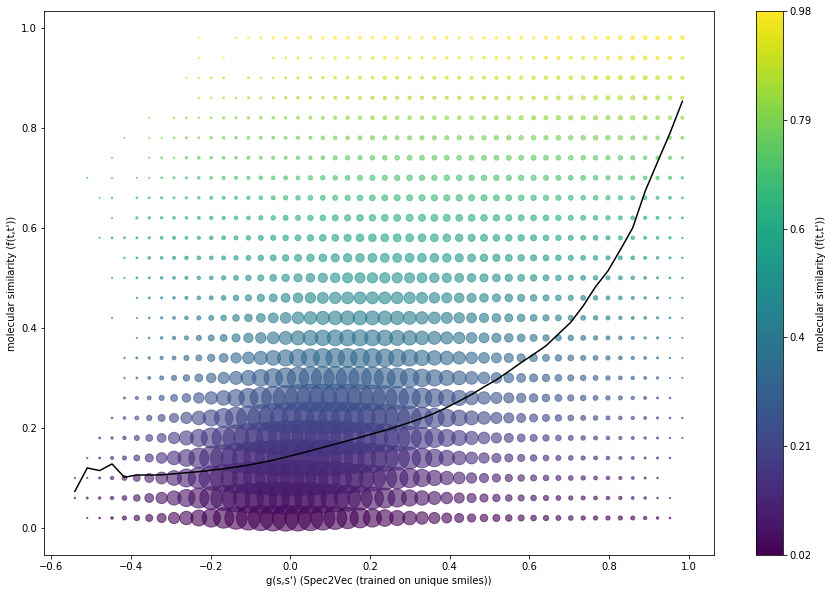

In [15]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Spec2Vec (trained on unique smiles)")

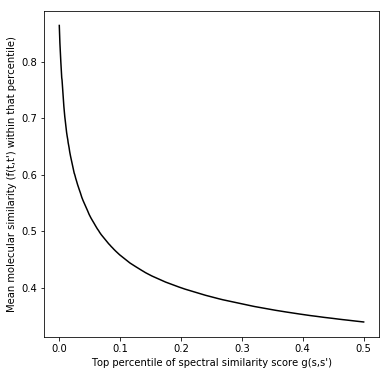

In [28]:
ref_score_w2v_cum_0 = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)

## 4.1. Spec2Vec: re-done, exp filter 0.01,

In [148]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_uniquesmiles_d300_w500_iter100_loss500_minpeak10_dec2_exp001.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=500, 
                             min_count=1, workers=8, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [149]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

All 'words' of the given documents were found in the trained word2vec model.
No tfidf model found.
  Calculated centroid vectors for  9550  of  9550  documents.  documents. 4400  of  9550  documents.6060  of  9550  documents. Calculated centroid vectors for  6240  of  9550  documents. 8150  of  9550  documents. Calculated centroid vectors for  8810  of  9550  documents.

### Calculate all-vs-all similarity matrix

In [150]:
from scipy import spatial
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

In [28]:
bins_x = 50
bins_y = 25
A = np.delete(M_sim_ctr.reshape(9550**2), remove_diagonal)
#B = np.delete(M_sim_morgan3.reshape(9550**2), remove_diagonal)

H, edges = np.histogramdd([A, B], bins = (bins_x, bins_y))

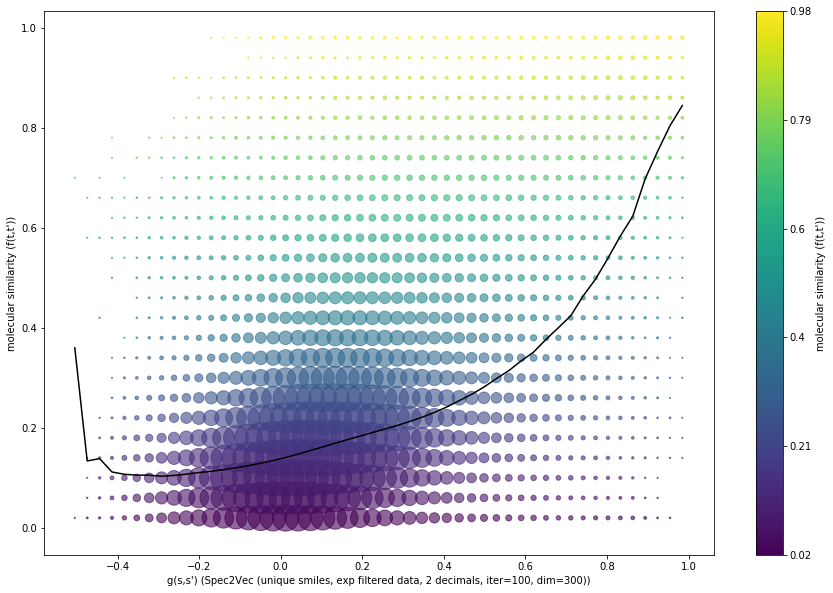

In [29]:
binned_scatter_plot(bins_x, bins_y, H, edges, "Spec2Vec (unique smiles, exp filtered data, 2 decimals, iter=100, dim=300)")

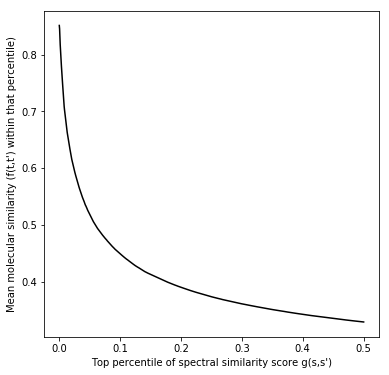

In [30]:
ref_score_w2v_cum_dec2_exp001_iter100_d300 = plot_high_sim_percentile(A, B, num_bins = 1000, show_top_percentile = 0.5)
np.save('spec2vec_uniquesmiles_dec2_exp001_iter100_d300.npy', ref_score_w2v_uniquesmiles_dec2_exp001_iter100_d300)

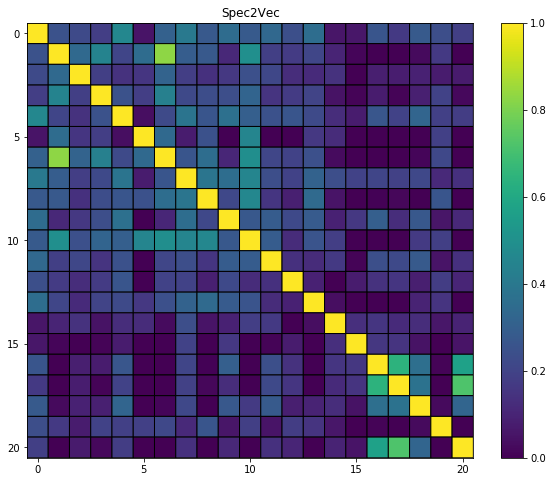

In [169]:
fig, ax = plt.subplots(figsize=(10,8))
c = ax.pcolor(M_sim_ctr[55:76,55:76], cmap='viridis', vmin=0, edgecolors='k', linewidths=1)
ax.set_title('Spec2Vec')
plt.ylim(21,0)
plt.xticks((5*np.arange(5)+0.5), ('0', '5', '10', '15', '20'))
plt.yticks((5*np.arange(5)+0.5), ('0', '5', '10', '15', '20'))
fig.colorbar(c, ax=ax)

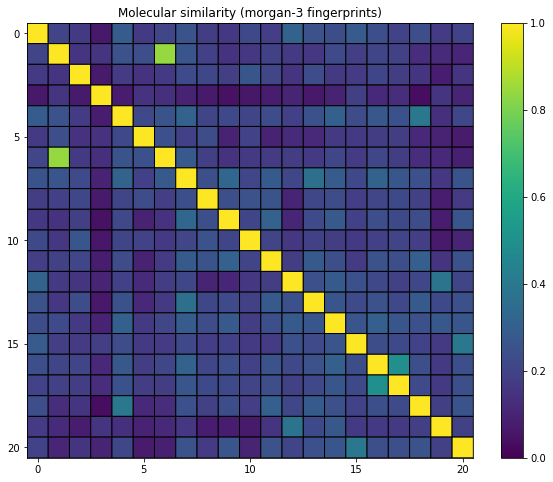

In [171]:
fig, ax = plt.subplots(figsize=(10,8))
c = ax.pcolor(M_sim_morgan3[55:76,55:76], cmap='viridis', vmin=0, edgecolors='k', linewidths=1)
ax.set_title('Molecular similarity (morgan-3 fingerprints)')
plt.ylim(21,0)
plt.xticks((5*np.arange(5)+0.5), ('0', '5', '10', '15', '20'))
plt.yticks((5*np.arange(5)+0.5), ('0', '5', '10', '15', '20'))
fig.colorbar(c, ax=ax)

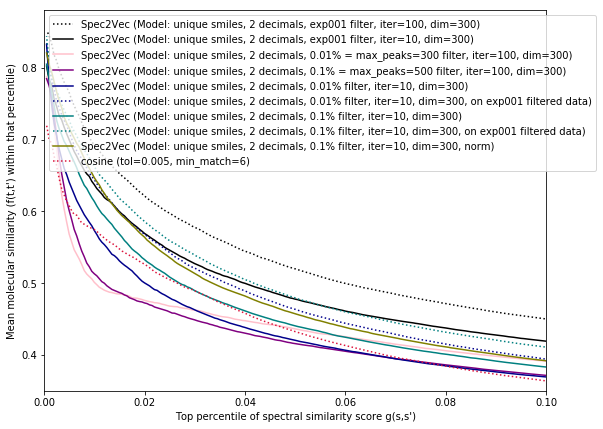

In [48]:
# Compare all:
num_bins = 1000
show_top_percentile = 0.5

#cmap2 = matplotlib.cm.get_cmap('winter')

fig, ax = plt.subplots(figsize=(9,7))
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_uniquesmiles_dec2_exp001_iter100_d300, 
         ':', color='black',
         label='Spec2Vec (Model: unique smiles, 2 decimals, exp001 filter, iter=100, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_uniquesmiles_dec2_exp001_iter10_d300, 
         color='black',
         label='Spec2Vec (Model: unique smiles, 2 decimals, exp001 filter, iter=10, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_uniquesmiles_dec2_001perc_maxpeaks300_iter10_d300_norm, 
         color='pink',
         label='Spec2Vec (Model: unique smiles, 2 decimals, 0.01% = max_peaks=300 filter, iter=100, dim=300)')

#plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_uniquesmiles_dec2_nofilter_iter10_d300, 
  #       color='purple',
  #       label='Spec2Vec (Model: unique smiles, 2 decimals, no filter, iter=10, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_uniquesmiles_dec2_01perc_maxpeaks10_iter10_d300_norm, 
         color='purple',
         label='Spec2Vec (Model: unique smiles, 2 decimals, 0.1% = max_peaks=500 filter, iter=100, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_uniquesmiles_dec2_001perc_filter_iter10_d300, 
         color='darkblue',
         label='Spec2Vec (Model: unique smiles, 2 decimals, 0.01% filter, iter=10, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_uniquesmiles_dec2_001perc_iter10_d300_exp001_data, 
         ':', color='darkblue',
         label='Spec2Vec (Model: unique smiles, 2 decimals, 0.01% filter, iter=10, dim=300, on exp001 filtered data)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_uniquesmiles_dec2_01perc_filter_iter10_d300, 
         color='teal',
         label='Spec2Vec (Model: unique smiles, 2 decimals, 0.1% filter, iter=10, dim=300)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_uniquesmiles_dec2_01perc_filter_iter10_d300_exp001data, 
         ':', color='teal',
         label='Spec2Vec (Model: unique smiles, 2 decimals, 0.1% filter, iter=10, dim=300, on exp001 filtered data)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_uniquesmiles_dec2_01perc_filter_iter10_d300_norm, 
         color='olive',
         label='Spec2Vec (Model: unique smiles, 2 decimals, 0.1% filter, iter=10, dim=300, norm)')

#plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_uniquesmiles_dec2_05perc_filter_iter10_d300_norm, 
#         color='green',
#         label='Spec2Vec (Model: unique smiles, 2 decimals, 0.5% filter, iter=10, dim=300, norm)')

#plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_uniquesmiles_dec2_05perc_filter_iter10_d300_exp001data, 
#         ':', color='green',
#         label='Spec2Vec (Model: unique smiles, 2 decimals, 0.5% filter, iter=10, dim=300, exp001 filtered data)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cosine_cum0005,':', 
         color='crimson', #cmap1(1.0), #'pink',
         label='cosine (tol=0.005, min_match=6)')


plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.xlim(0, 0.1)
plt.ylim(0.35, 0.88)
plt.savefig('Top_percentile_comparison_uniquesmiles_filtering.pdf')

## Comparison plots

In [45]:
ref_score_cosine_cum002 = np.load('cosine_percentile_tol002_minmatch6.npy')
ref_score_cosine_cum0005 = np.load('cosine_percentile_tol0005_minmatch6.npy')

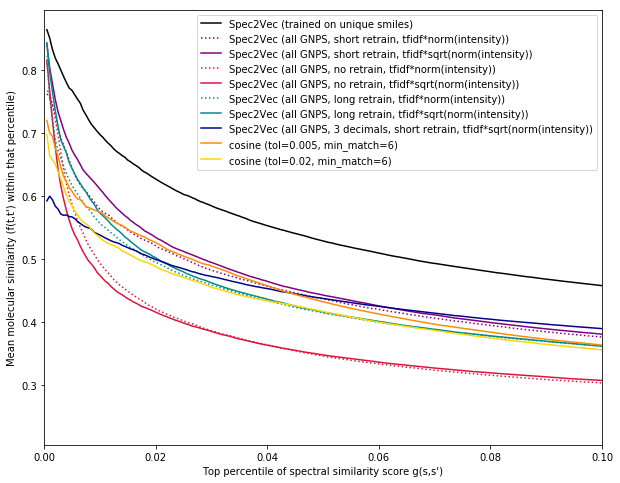

In [116]:
# Compare all:
num_bins = 1000
show_top_percentile = 0.5

cmap1 = matplotlib.cm.get_cmap("gnuplot") #('autumn') #('BuPu')
cmap2 = matplotlib.cm.get_cmap('winter') #('YlGn')

fig, ax = plt.subplots(figsize=(10,8))
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_0, color='black',
         label='Spec2Vec (trained on unique smiles)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_1, ':', 
         color='purple', #cmap1(0.0), 
         label='Spec2Vec (all GNPS, short retrain, tfidf*norm(intensity))')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_2, 
         color='purple', #(0.2), 
         label='Spec2Vec (all GNPS, short retrain, tfidf*sqrt(norm(intensity))')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_3, ':', 
         color='crimson', #cmap1(0.4), #'pink',
         label='Spec2Vec (all GNPS, no retrain, tfidf*norm(intensity))')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_4, 
         color='crimson', #cmap1(0.5), #'pink',
         label='Spec2Vec (all GNPS, no retrain, tfidf*sqrt(norm(intensity))')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_6, ':', 
         color='darkcyan', #cmap1(0.7), #'pink',
         label='Spec2Vec (all GNPS, long retrain, tfidf*norm(intensity))')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_5, 
         color='darkcyan', #cmap1(0.8), #'pink',
         label='Spec2Vec (all GNPS, long retrain, tfidf*sqrt(norm(intensity))')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_7, 
         color='darkblue', #cmap1(1.0), #'pink',
         label='Spec2Vec (all GNPS, 3 decimals, short retrain, tfidf*sqrt(norm(intensity))')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cosine_cum0005, 
         color='darkorange', #cmap1(1.0), #'pink',
         label='cosine (tol=0.005, min_match=6)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cosine_cum002, 
         color='gold', #cmap1(1.0), #'pink',
         label='cosine (tol=0.02, min_match=6)')

plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.xlim(0, 0.1)
plt.savefig('Top_percentile_comparison_allGNPS_02.pdf')

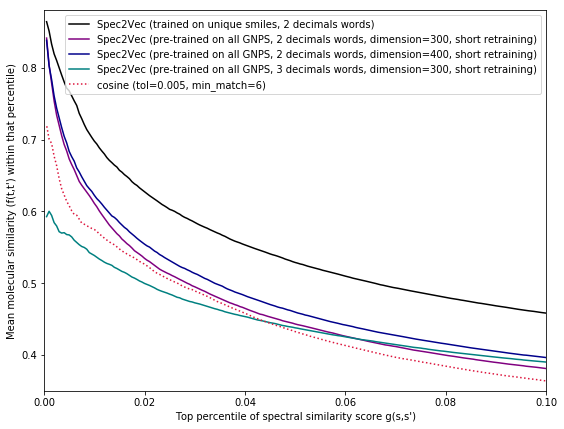

In [49]:
# Compare all:
num_bins = 1000
show_top_percentile = 0.5

cmap1 = matplotlib.cm.get_cmap("gnuplot") #('autumn') #('BuPu')
cmap2 = matplotlib.cm.get_cmap('winter') #('YlGn')

fig, ax = plt.subplots(figsize=(9,7))
plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_0, color='black',
         label='Spec2Vec (trained on unique smiles, 2 decimals words)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_2, 
         color='purple', #(0.2), 
         label='Spec2Vec (pre-trained on all GNPS, 2 decimals words, dimension=300, short retraining)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_2b, 
         color='darkblue', #cmap1(1.0), #'pink',
         label='Spec2Vec (pre-trained on all GNPS, 2 decimals words, dimension=400, short retraining)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_7, 
         color='teal', #cmap1(1.0), #'pink',
         label='Spec2Vec (pre-trained on all GNPS, 3 decimals words, dimension=300, short retraining)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cosine_cum0005,':', 
         color='crimson', #cmap1(1.0), #'pink',
         label='cosine (tol=0.005, min_match=6)')


plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.xlim(0, 0.1)
plt.ylim(0.35, 0.88)
plt.savefig('Top_percentile_comparison_allGNPS_03.pdf')

In [114]:
np.save('spec2vec_allGNPS_0.npy', ref_score_w2v_cum_0)
np.save('spec2vec_allGNPS_1.npy', ref_score_w2v_cum_1)
np.save('spec2vec_allGNPS_2.npy', ref_score_w2v_cum_2)
np.save('spec2vec_allGNPS_2b.npy', ref_score_w2v_cum_2b)
np.save('spec2vec_allGNPS_3.npy', ref_score_w2v_cum_3)
np.save('spec2vec_allGNPS_4.npy', ref_score_w2v_cum_4)
np.save('spec2vec_allGNPS_5.npy', ref_score_w2v_cum_5)
np.save('spec2vec_allGNPS_6.npy', ref_score_w2v_cum_6)
np.save('spec2vec_allGNPS_7.npy', ref_score_w2v_cum_7)
np.save('spec2vec_allGNPS_8.npy', ref_score_w2v_cum_8)

In [34]:
# load previously calculated curves
ref_score_w2v_cum_0 = np.load('spec2vec_allGNPS_0.npy')
ref_score_w2v_cum_1 = np.load('spec2vec_allGNPS_1.npy')
ref_score_w2v_cum_2 = np.load('spec2vec_allGNPS_2.npy')
ref_score_w2v_cum_2b = np.load('spec2vec_allGNPS_2b.npy')
ref_score_w2v_cum_3 = np.load('spec2vec_allGNPS_3.npy')
ref_score_w2v_cum_4 = np.load('spec2vec_allGNPS_4.npy')
ref_score_w2v_cum_5 = np.load('spec2vec_allGNPS_5.npy')
ref_score_w2v_cum_6 = np.load('spec2vec_allGNPS_6.npy')
ref_score_w2v_cum_7 = np.load('spec2vec_allGNPS_7.npy')
ref_score_w2v_cum_8 = np.load('spec2vec_allGNPS_8.npy')
#ref_score_w2v_cum_2_7 = np.load('spec2vec_allGNPS_2_7.npy')
ref_score_w2v_cum_2_8 = np.load('spec2vec_allGNPS_2_8.npy')

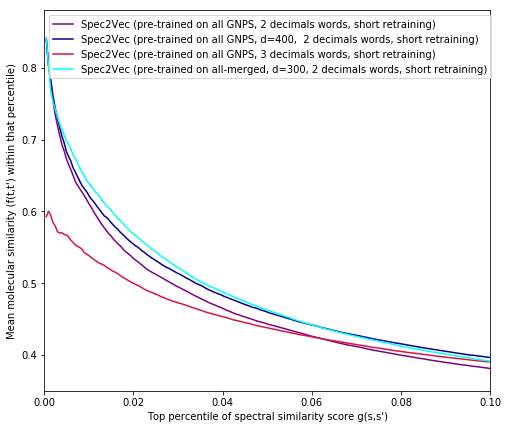

In [63]:
# Compare all:
num_bins = 1000
show_top_percentile = 0.5

cmap1 = matplotlib.cm.get_cmap("gnuplot") #('autumn') #('BuPu')
cmap2 = matplotlib.cm.get_cmap('winter') #('YlGn')

fig, ax = plt.subplots(figsize=(8,7))

#plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_1_1, 
#         color='olive', #cmap1(1.0), #'pink',
#         label='Spec2Vec (pre-trained on all GNPS, 1 decimals words, short retraining)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_2, 
         color='purple', #(0.2), 
         label='Spec2Vec (pre-trained on all GNPS, 2 decimals words, short retraining)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_2b, 
         color='darkblue', #cmap1(1.0), #'pink',
         label='Spec2Vec (pre-trained on all GNPS, d=400,  2 decimals words, short retraining)')

#plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_2_8, 
#         color='blue', #cmap1(1.0), #'pink',
#         label='Spec2Vec (pre-trained on all GNPS, loss=peak, w=500, iter=100,  2 decimals words, short retraining)')

#plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_2_9, 
#         color='cyan', #cmap1(1.0), #'pink',
#         label='Spec2Vec (pre-trained on all GNPS, no losses, w=500, iter=100,  2 decimals words, short retraining)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_7, 
         color='crimson', #cmap1(1.0), #'pink',
         label='Spec2Vec (pre-trained on all GNPS, 3 decimals words, short retraining)')

#plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_8,':', 
#         color='red', #cmap1(1.0), #'pink',
#         label='Spec2Vec (pre-trained on all GNPS, d = 400, 3 decimals words, short retraining)')

plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_w2v_cum_merged_2_0, 
         color='cyan', #cmap1(1.0), #'pink',
         label='Spec2Vec (pre-trained on all-merged, d=300, 2 decimals words, short retraining)')


plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.xlim(0, 0.1)
plt.ylim(0.35, 0.88)
plt.savefig('Top_percentile_comparison_allGNPS_04.pdf')